In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
from time import time
from IPython import get_ipython
import winsound

class Beeper:

    def __init__(self, threshold):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            winsound.Beep(2500,1000)
        self.start_time = None


beeper = Beeper(60)

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)

In [4]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

<div class="float-bar-whh" style="display:block;">
    <center><span class="new-name-whh">Finance</span></center>
</div>

# Analysize variables.

In [5]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [6]:
# Define an iterator for reading rows.
def rows_iter(index=True):
    if index:
        for index, line in enumerate(rows_iter(index=False)):
             yield index, line
    else:
        empl_file = r"../fin/finance_profiles.csv"
        with open(empl_file,"rb") as f:
            reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
            for line in reader:
                del line[1]
                yield line

In [7]:
# # Get unique values for each variable.
# unique_values = []
# for i in range(33):
#     unique_values.append(set())
# # Get unique values for each variable.
# for idx, line in rows_iter():
#     for i in range(33):
#         unique_values[i].add(line[i])
# for idx, values in enumerate(unique_values):
#     print("[Column {}] ".format(idx)+str(len(values)))

In [8]:
# # Get unique values for "ticker-naics-ticcode" tuple.
# unique_tuples = set()
# for idx, line in rows_iter():
#     if idx == -1:
#         break
#     unique_tuples.add((line[21], line[25], line[31])) 

In [9]:
# ticker_dict = {}
# for ticker, naics, ticcode in unique_tuples:
#     if ticcode in ticker_dict:
#         ticker_dict[ticcode] += [(ticker, naics)]
#     else:
#         ticker_dict[ticcode] = [(ticker, naics)]
# ticker_dict

In [10]:
# One block to convert data to pd.DataFrame.
entries_lst = []
for idx, line in rows_iter():
    if idx == 100: # Control number of rows.
        break
    entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)

entries_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,f035a384-cd3c-3185-8340-c0ac1459d9ae,2001,1,-1,0,-1,0,Bronx,United States,0,False,None,False,None,False,True,,finacial associate,,citi,citi,C,XNYS,True,,522291,False,,False,,,BBG000FY4S11,1503620559000
1,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1988-01-01,False,1993-01-01,False,False,1827,"""Laurea, Discipline Economico-Sociali (DES)"",Laurea,Discipline Economico-Sociali,DES",,Università Bocconi,Università Bocconi,UNIVERSITY,ITALY,False,,,True,4,False,,,,1530808751000
2,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1993-01-01,False,1995-02-01,True,False,761,,,TIME_OFF,TIME_OFF,TIME_OFF,OTHER,False,Italy,TIME_OFF,False,,False,,,,1530808751000
3,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1995-03-01,True,2005-08-01,True,False,3806,"Sales Support Assicurazioni & Riassicurazioni,sales support",MARKETING,Europ Assistance Italia,europ assistance,,ITALY,False,,52,False,,False,,,,1530808751000
4,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2005-09-01,True,2013-12-01,True,False,3013,"Responsabile Assicurazioni; Banche e Mercato Finanziario,responsabile",,Mondial Assistance Italia,Mondial Assistance Italia,,,False,,,False,,False,,,,1530808751000
5,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2014-01-01,True,None,False,True,1834,"National Account Manager Allianz Group Italy,account manager",,Allianz Worldwide Partners,Allianz Worldwide Partners,,,False,"milan area, italy",,False,,False,,,,1530808751000
6,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2001-01-01,True,2006-07-01,True,False,2007,"Regional Account Executive,account executive",,MCI Corporation,mci,,UNITED STATES,False,,51,False,,False,,,,1518862557000
7,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2006-09-01,True,2007-04-01,True,False,212,"Regional Account Manager,account manager",,Washington Mutual Card Services,washington mutual,,UNITED STATES,False,,52,False,,False,,,,1518862557000
8,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2007-03-01,True,None,False,True,4332,"Student Teacher,student,teacher",,NYC Board of Education,nyc board of,,UNITED STATES,False,,61,False,,False,,,,1518862557000
9,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2008-01-01,False,2014-01-01,False,False,2192,""""""" Bachelor of Science """" BA, Special Education and Teaching"","""""" Bachelor of Science """" BA"",Special Education and Teaching",,Touro College,Touro College,UNIVERSITY,UNITED STATES,False,,,True,4,False,,,,1518862557000


In [11]:
# Get an example.
entry = samples_lst[13]
for i in range(len(entry)):
    print("[Column {}] ".format(i),entry[i])

[Column 0]  f6e5ddfa-3c7a-3139-88c1-3015a1f4ce9d
[Column 1]  1978
[Column 2]  1
[Column 3]  -1
[Column 4]  0
[Column 5]  -1
[Column 6]  0
[Column 7]  Geneva
[Column 8]  Switzerland
[Column 9]  5
[Column 10]  False
[Column 11]  2008-06-01
[Column 12]  True
[Column 13]  2008-08-01
[Column 14]  True
[Column 15]  False
[Column 16]  61
[Column 17]  Operations Summer Analyst,operations,analyst
[Column 18]  OPERATIONS
[Column 19]  Goldman Sachs
[Column 20]  Goldman Sachs
[Column 21]  GS
[Column 22]  XNYS
[Column 23]  True
[Column 24]  new york / new jersey, united states
[Column 25]  523110
[Column 26]  False
[Column 27]  
[Column 28]  False
[Column 29]  
[Column 30]  
[Column 31]  BBG000C6CFJ5
[Column 32]  1531074992000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the companies (listed [here](#company_lst));
- `firing` if it changed its company from one of the companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the companies and not recogized as `firing`.

In [12]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*7 # "birth_year","gender","skill1","skill2","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        self.company = [None]*2 # "ticcode", "naics" 
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['','']+self.company
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]+self.company
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]+self.company
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,5,8,9,10]]
        if entry[6] is not None:
            self.profile[3] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3] != "-1" and entry[26] == "False" and not sum([
            re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
            for x in ["intern","internship","trainee","student","summer"]
        ]):
            if self.company[0] != entry[31]:
                if entryProcessor.is_fin(self.company[1]):
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                self.company = [None]*2
                if entryProcessor.is_fin(entry[25]):
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]+"@"+entry[22] if entry[21]!="" else ""
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    self.company = [entry[31],entry[25]]
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
    
    def is_fin(naics):
        return naics is not None and len(naics)>=2 and naics[:2]=='52'
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [13]:
# Read, Identify & Aggregate.

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
for idx, entry in itertools.chain(rows_iter(),[(None,[None]*40)]):
    if idx == -1: # End point.
        break
    empl_changes_lst += career.read(entry)

varlist = [
    "type","ticker","yrmth","birth","gender","skill1","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom","ticcode","naics"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df["ticker"] = "All"
empl_changes_df


,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,ticcode,naics
0,hiring,All,201611,1992,2,Hospitality,,United Arab Emirates,4,False,"Food And Beverage Attendant,food and beverage,attendant",OPERATIONS,,,,BBG000BB4980,523
1,hiring,All,201404,1979,0,Hospitality,,Vietnam,0,False,Jr.Sous chef,,,,,,524
2,hiring,All,None,1972,2,Technical Product Management,,United States,0,False,"Senior Data Modeler,senior,data",,,,,BBG000C2PW58,523920
3,leaving,All,None,1972,2,Technical Product Management,,United States,0,False,"Senior Data Modeler,senior,data",,51,NaN,0,BBG000C2PW58,523920
4,hiring,All,199100,1969,2,Technical Product Management,Operations Management,Other,4,False,"Software developer,software developer",TECHNOLOGY,,,,BBG000FLLY08,524126
5,firing,All,199200,1969,2,Technical Product Management,Operations Management,Other,4,False,"Software developer,software developer",TECHNOLOGY,,12,0,BBG000FLLY08,524126
6,hiring,All,201309,1989,0,Administration,Non-Profit and Community,United States,4,False,"Internal Sales Associate,sales associate",MARKETING,,,,BBG000BKFBD7,523920
7,leaving,All,201508,1989,0,Administration,Non-Profit and Community,United States,4,False,"Internal Sales Associate,sales associate",MARKETING,,23,0,BBG000BKFBD7,523920
8,hiring,All,199711,2001,1,Recruiting,,United States,4,False,"Senior Benefits Representative,senior,representative",,,,,,52
9,hiring,All,200910,1965,2,Business Development,Business Development,Costa Rica,5,False,"Jefe de Credito Empresarial,chief",,,,,,52


A block prepared for counting annual employment.

In [14]:
res_counter = Counter()
for idx, entry in rows_iter():
    if idx == -1: # End point.
        break
    if entryProcessor.is_fin(entry[25]) and entry[3] != "-1" and entry[26] == "False" and not sum([
        re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
        for x in ["intern","internship","trainee","student","summer"]
    ]):
        if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
            # print([entry[x] for x in [11,12,13,14,15]])
            res_counter += Counter(
                range(
                    pd.to_datetime(entry[11]).year,
                    pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                )
            )

empl_by_years = pd.Series(res_counter).reset_index()
empl_by_years.columns = ["year", "employment"]
empl_by_years["ticker"] = "All"
empl_by_years = empl_by_years.groupby(["ticker", "year"]).sum().reset_index()

# empl_by_years

# Summarize and plot.

<a id='company_lst'></a>
**For ALL positions in:**
- Financial companies. (NAICS==52xxxx)

All firms are combined in the following analysis.

In [15]:
# Colors.
color_styles = ['g','r','c','m','y']
line_styles = ['-','--','-']
marker_styles = ['o','^','^']
xlefts = [1990]

In [16]:
# A iterator for plots.
number_of_uniques = len(empl_changes_df["ticker"].unique())
def iterator_for_axis(col=1, one_size=(12,6), rep_time=1, number_once=number_of_uniques, fig_func=None):
    all_needs=number_once*rep_time
    row=-(-all_needs//col)
    fig, axs = plt.subplots(row,col,figsize=(one_size[0]*col, one_size[1]*row))
    if col>1 and row>1:
        axs=[x for y in axs for x in y]
    elif col==1 and row==1:
        axs=[axs]
    if fig_func is not None:
        fig_func(fig)
    for ax in axs[all_needs:]:
        ax.axis('off')
    return iter(axs)

In [17]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,ticcode,naics
count,9973711,9973711,9584009,9973711,9973711,9973711,9973711,9973711,9973711,9973711,9973711,9973711,9973711,9792459,9973711,9973711,9973711
unique,3,1,1089,84,3,44,45,383,8,2,2324947,874,744,866,70,838,48
top,hiring,All,201506,2001,2,Banking and Finance,,United States,4,False,"Customer Service Representative,customer service representative",,,,,,52
freq,6837334,9973711,70456,1745643,4534953,1835737,2913024,3910641,4078764,9497053,69995,5362742,8100172,6837334,6837334,5066378,4836823


## Count the number of employees from Dec., 1989 on.

Note: 
- This block counts the number of currently employment for the firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes after some time, we will have the correct number after all the employment before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

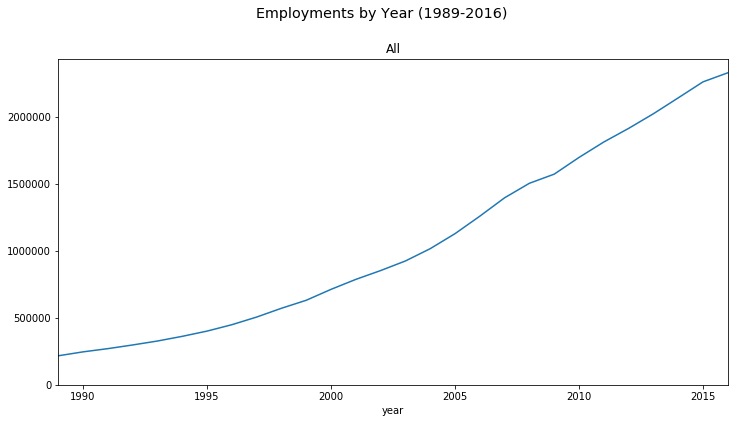

In [18]:
# count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
# empl_by_years = count_by_years.groupby(['ticker','type']).apply(
#     lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
# ).reset_index(drop=True).pivot_table(
#     index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
# ).assign(
#     employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
# ).drop('cumsum',axis=1).reset_index()
# empl_by_years.columns = empl_by_years.columns.droplevel('type')

# Plot.
for (ticker, col), ax in zip(
    empl_by_years.pivot_table(
        index='year',columns='ticker',values='employment',fill_value=0
    ).loc[lambda df:(df.index>=1989)&(df.index<=2016)].iteritems(),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Employments by Year (1989-2016)",fontsize="x-large",y=1))
):
    col.plot(ax=ax, title=ticker).set_ylim(bottom=0)

plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

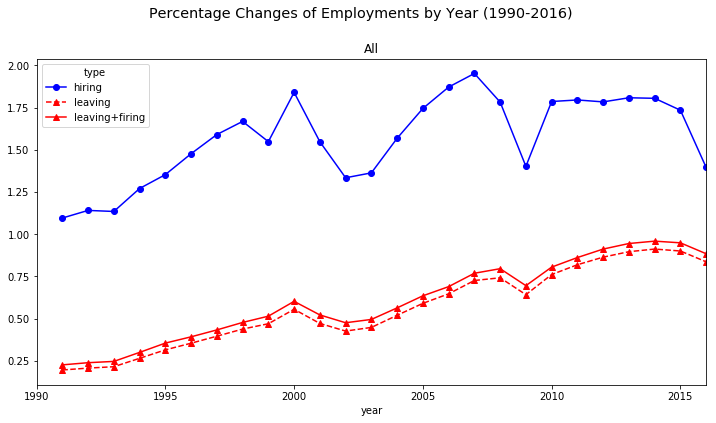

In [19]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1991)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# prop_by_months.pivot_table(
#     index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
# ).reset_index().assign(
#     **{"leaving+firing":lambda df:df.leaving+df.firing}
# ).drop("firing",axis=1).drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
#     xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^'],
#     title="Percentage Changes of Employments by Year (1990-2016)", figsize=(12,6)
# )


# Plot by year.
for (ticker, grp), ax, xleft in zip(
    prop_by_months.pivot_table(
        index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{"leaving+firing":lambda df:df.leaving+df.firing}
    ).drop("firing",axis=1).groupby('ticker'),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Percentage Changes of Employments by Year (1990-2016)", fontsize="x-large", y=1)),
    xlefts
):
    grp.drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
        ax=ax, title=ticker, xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^']
    )
plt.show()

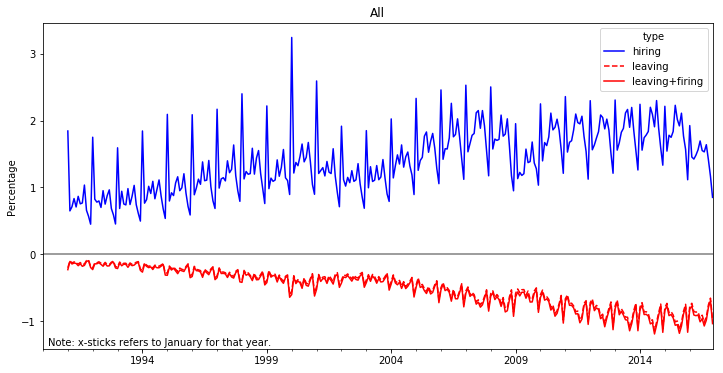

In [20]:
start_year=1990
end_year=2016
for (ticker, grp),ax,xleft in zip(
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).set_index('yrmth').groupby('ticker'),
    iterator_for_axis(), xlefts
):
    grp.loc[lambda df:df.year>=xleft][['hiring','leaving','leaving+firing']].plot(
        ax=ax,title=ticker,style=['b-','r--','r-'],
        xlim=(pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016))),
        #xticks=[pd.Period('{}-01'.format(int(x*5+1990))) for x in range(5)]
    )
    ax.set_ylabel('Percentage')
    ax.set_xlabel('')
    ax.hlines(0,pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016)),colors='tab:gray')
    ax.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
plt.show()

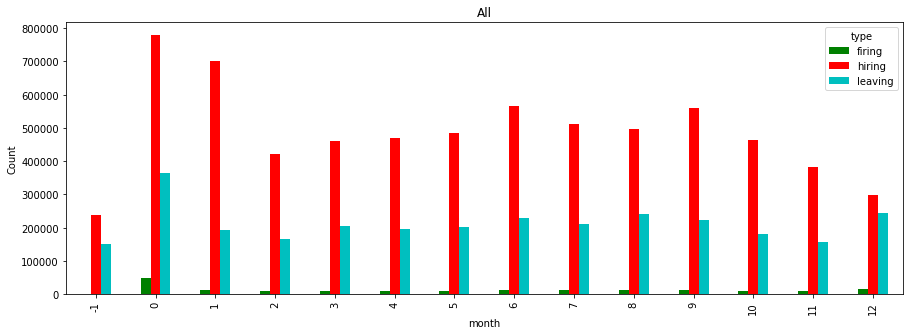

In [21]:
# Month composition.
display(HTML("<center><strong>Month Composition (-1: None, 0: Invalid month)</strong></center>"))
for idx, grp in empl_changes_df.groupby(['ticker']):
    grp.assign(count=1).pivot_table(
        index = 'month', columns = 'type', values='count', aggfunc='sum', fill_value=0
    ).plot.bar(figsize=(15,5),color=color_styles,title=idx).set_ylabel("Count")
    plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

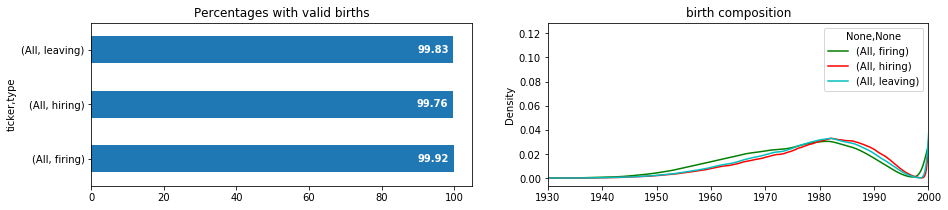

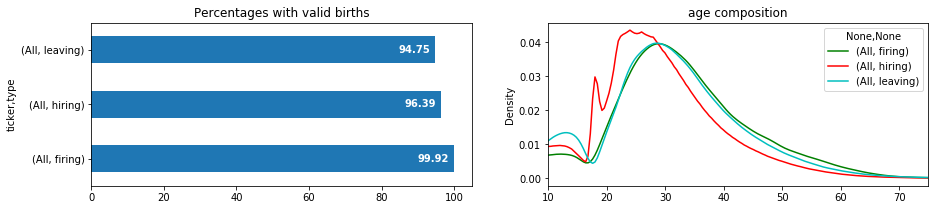

In [22]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
var, xlim = "birth", (1930,2000)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
var, xlim = "age", (10,75)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()

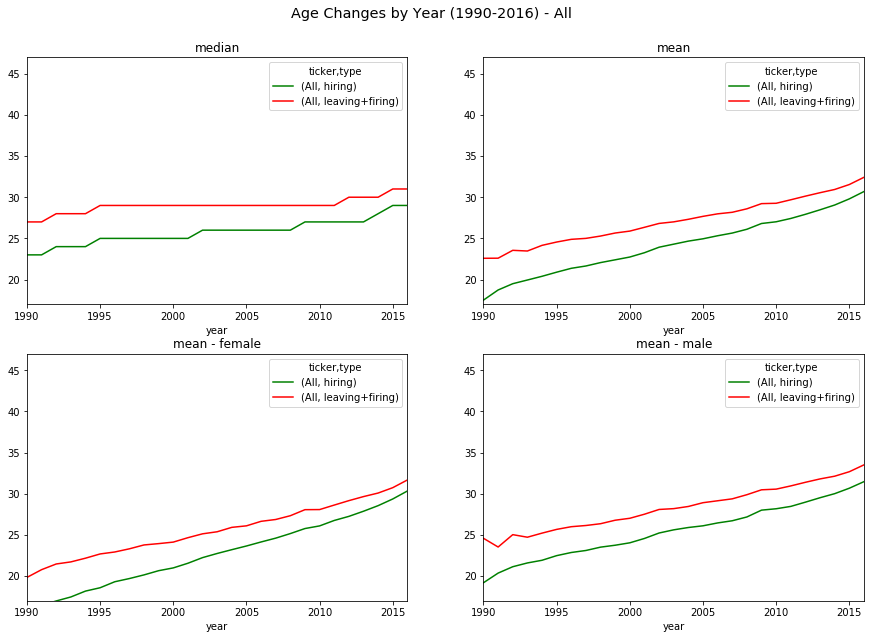

In [23]:
# Age changes by year.
for (ticker, grp), xleft in zip(
    birth_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('Age Changes by Year (1990-2016) - {}'.format(ticker),fontsize='x-large',y=0.95)
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='median'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
    grp.loc[empl_changes_df.gender=='1'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
    grp.loc[empl_changes_df.gender=='2'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
    plt.show()

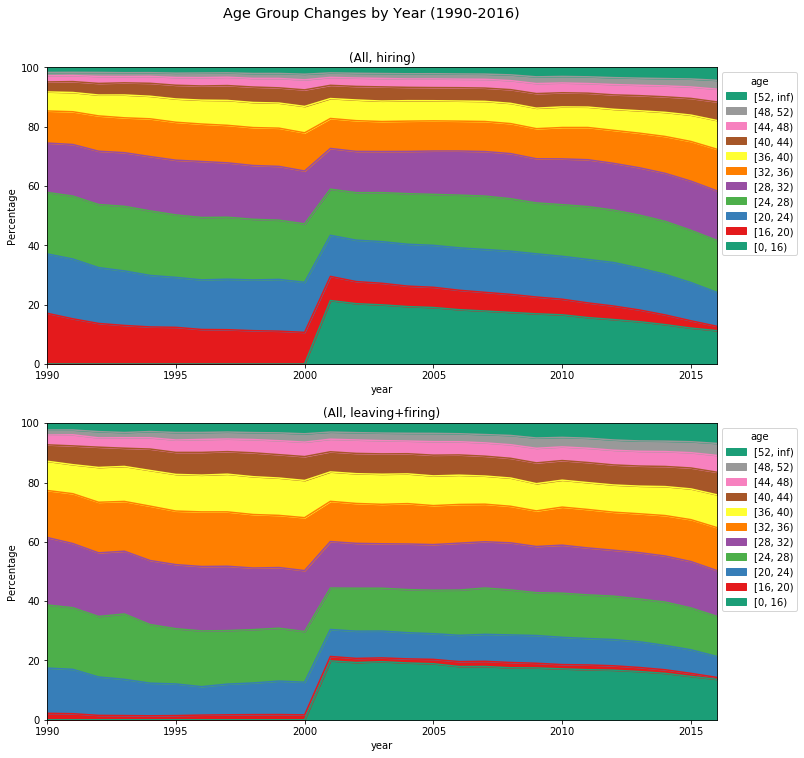

In [24]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),xlim=(xleft,2016),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns],
        xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

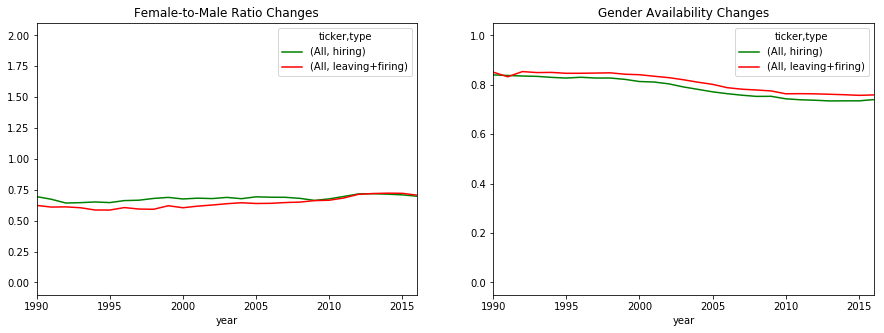

In [25]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1,
        xticks=[1990+5*x for x in range(6)]
    )
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x!='0').sum()/x.size)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Gender Availability Changes",ax=ax2,
        xticks=[1990+5*x for x in range(6)]
    )
    plt.show()

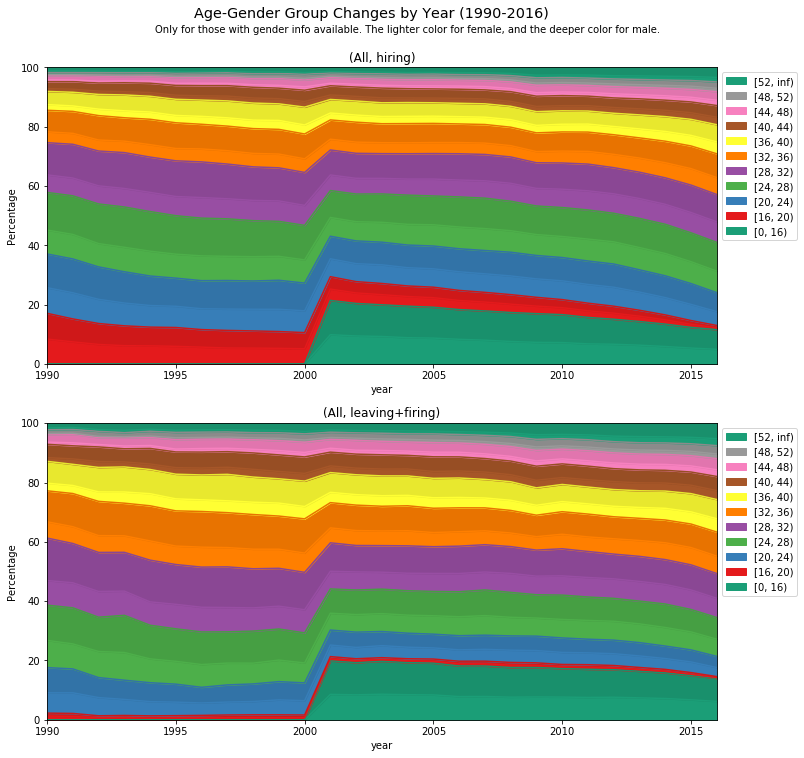

In [26]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
def fig_func(fig):
    fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    fig.text(0.25,0.92,
          "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=fig_func
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990+5*x for x in range(6)],
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

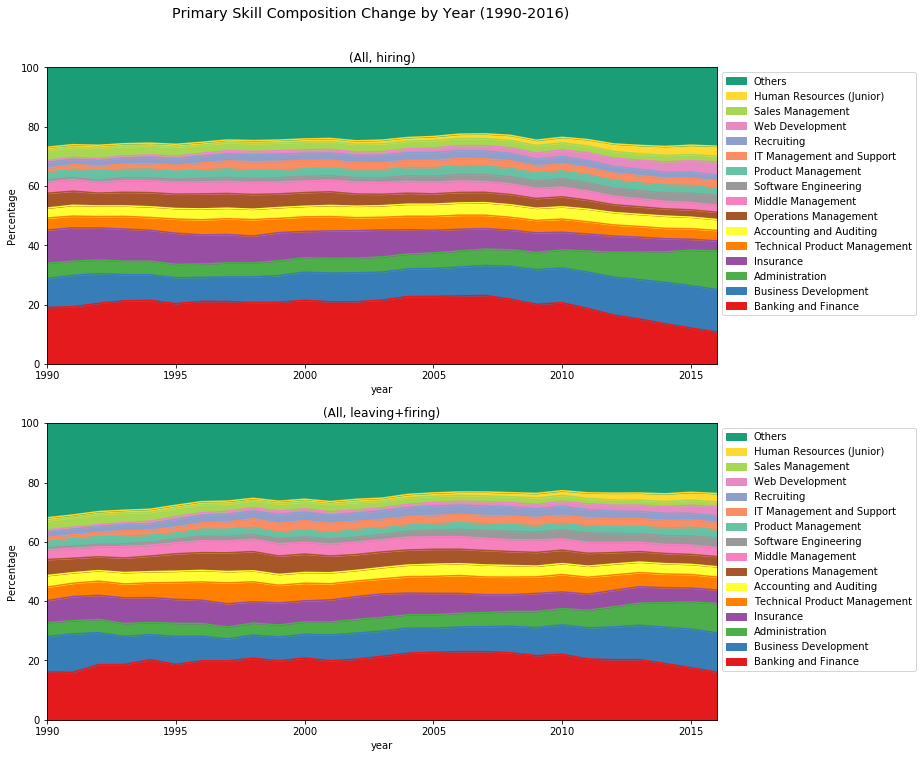

In [27]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill1_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [28]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill1_ord_unif[i]+"</strong>"))
    to_plot = empl_changes_df.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill1==skill1_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30)
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Vice President,39394,2.15,Accounting,38.78,Bachelors,38.65
1,Analyst,26689,1.45,Oversight,19.37,None/Unknown,27.51
2,Branch Manager,21848,1.19,Marketing,15.30,Masters excl. MBA,13.86
3,Associate,21274,1.16,Business,10.24,MBA,13.29
4,Director,19644,1.07,Operations,6.59,Doctorate (PhD/JD/MD),2.43
5,Managing Director,17133,0.93,Technology,4.49,High school,2.18
6,Relationship Manager,14508,0.79,Hr,3.23,Associates,1.25
7,Manager,12774,0.70,Legal,0.92,Vocational degree,0.84
8,Personal Banker,11313,0.62,Production,0.56,NaN,NaN
9,Financial Advisor,11172,0.61,Management,0.52,NaN,NaN


,job_role,depmt,edu,f_elite
9085417,"Vice President Key Accounts,vice president,"","",accounts",,MBA,False
3503373,"Investment Analyst,analyst",ACCOUNTING,MBA,False
4040328,"Business Analysis & Change Depositary Operations,business,"","",operations",OPERATIONS,Bachelors,False
2904080,"Customer Service Representative,customer service representative",MARKETING,Bachelors,False
8729453,"Project Management Office (PMO Lead),project management,office,lead",,Vocational degree,False
9371977,"Chief Economist/Consultant,chief",OVERSIGHT,Bachelors,True
5556434,"Sales and Service Coach,sales,service,coach",MARKETING,None/Unknown,False
8200979,"Associate Manager,associate manager",,Bachelors,False
3981094,"Partner,partner",OVERSIGHT,Masters excl. MBA,False
1422098,"Monitoring Director,director",OVERSIGHT,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Estagiário,9564,0.85,Marketing,34.10,Bachelors,34.83
1,Estagiária,5666,0.51,Accounting,19.90,None/Unknown,26.75
2,Stagiaire,5356,0.48,Business,13.42,Masters excl. MBA,20.45
3,Sales Manager,3656,0.33,Oversight,9.02,MBA,8.37
4,Analyst,3653,0.33,Operations,6.46,High school,4.14
5,Customer Service Representative,3618,0.32,Hr,5.59,Vocational degree,3.65
6,Administrative Assistant,3326,0.30,Technology,5.18,Doctorate (PhD/JD/MD),1.25
7,Auxiliar Administrativo,3112,0.28,Management,3.45,Associates,0.56
8,Gerente,3084,0.27,Production,1.67,NaN,NaN
9,Caixa,2855,0.25,Legal,1.19,NaN,NaN


,job_role,depmt,edu,f_elite
2888544,"Ger. Adm Vendas III,adm,vendas,3",,MBA,False
25500,"Auxiliar operativo,auxiliar",,Bachelors,False
1842084,"Becaria,becaria",,Masters excl. MBA,False
3964586,"Formation en alternance,formation",,None/Unknown,False
7453726,"Accountant Clerk,accountant,clerk",,Bachelors,False
9818655,"Chargé de clientèle Agricole,chargé de clientèle",,None/Unknown,False
86720,"Gerente de Logística nacional e internacional - Projeto Rio2016,gerente",,Bachelors,False
1565590,"Compliance Analyst,analyst",OVERSIGHT,Masters excl. MBA,False
5815856,"Project Coordinator,project coordinator",,Masters excl. MBA,False
2663167,"Analista Financeiro / Planejamento Estratégico,analista,financeiro",,MBA,False


,job_role,count,prop,depmt,prop,edu,prop
0,Customer Service Representative,21645,2.85,Marketing,34.16,Bachelors,49.22
1,Administrative Assistant,14365,1.89,Accounting,33.29,None/Unknown,25.34
2,Teller,11345,1.49,Hr,7.75,Masters excl. MBA,8.19
3,Bank Teller,11117,1.46,Operations,7.65,High school,5.75
4,Executive Assistant,10128,1.33,Business,4.92,Associates,5.36
5,Financial Advisor,4549,0.60,Oversight,4.90,MBA,3.01
6,Personal Banker,4424,0.58,Technology,3.83,Vocational degree,2.08
7,Analyst,4298,0.57,Legal,1.47,Doctorate (PhD/JD/MD),1.05
8,Financial Representative,3939,0.52,Production,1.31,NaN,NaN
9,Office Manager,3903,0.51,Management,0.73,NaN,NaN


,job_role,depmt,edu,f_elite
5766323,"Marketer,marketer",,High school,False
2435357,"QC Inspector,quality control,inspector",PRODUCTION,Bachelors,False
2686312,"Team Assistant,assistant",,None/Unknown,False
6340437,"Global Marketing Assistant,marketing assistant",MARKETING,Bachelors,False
8406552,"Assistant Client Service Specialist,assistant,client,service,specialist",MARKETING,Bachelors,False
1465912,"Bank Teller / Customer Service,bank teller,customer service","MARKETING,ACCOUNTING",Associates,False
3486478,"Sales Service Representative,sales,service,representative",MARKETING,None/Unknown,False
7859486,bank teller,ACCOUNTING,Bachelors,False
2073356,vendeuse,,None/Unknown,False
7384876,"Loan Servicing Specialist II via Accountemps,specialist,2,"",""",ACCOUNTING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Financial Advisor,21851,3.39,Accounting,44.50,None/Unknown,42.44
1,Agent,8782,1.36,Marketing,20.06,Bachelors,39.84
2,Insurance Agent,8247,1.28,Oversight,13.32,Masters excl. MBA,5.40
3,Account Executive,8013,1.24,Business,10.15,MBA,4.81
4,Account Manager,7438,1.15,Hr,5.47,High school,2.83
5,Vice President,6758,1.05,Operations,3.15,Associates,2.07
6,Underwriter,5688,0.88,Technology,1.44,Doctorate (PhD/JD/MD),1.58
7,Claims Adjuster,3673,0.57,Production,0.83,Vocational degree,1.03
8,Financial Consultant,3579,0.56,Legal,0.64,NaN,NaN
9,Financial Planner,3468,0.54,Management,0.45,NaN,NaN


,job_role,depmt,edu,f_elite
7019785,"Senior Adjuster,senior,adjuster",,None/Unknown,False
668939,"Executive Director,executive director",OVERSIGHT,None/Unknown,False
3844161,"Key Account Executive,key account,account executive",,Bachelors,False
3634748,"Claims Adjuster,claims adjuster",ACCOUNTING,Bachelors,False
2951177,"Claims,claims",ACCOUNTING,None/Unknown,False
7466031,"Insurance Claim Consultant,insurance,consultant",ACCOUNTING,Bachelors,False
8028759,Actuary,,Bachelors,False
4670937,Benefit Plan Compliance,"HR,OVERSIGHT",Bachelors,False
588394,"Case Manager,case manager",,Bachelors,False
4256404,"Financial Representative,financial,representative",ACCOUNTING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Business Analyst,13820,3.15,Technology,44.46,Bachelors,42.92
1,Project Manager,6939,1.58,Business,12.51,None/Unknown,28.92
2,Consultant,6895,1.57,Marketing,9.74,Masters excl. MBA,15.42
3,Senior Business Analyst,4796,1.09,Accounting,9.07,MBA,6.92
4,Software Engineer,3861,0.88,Operations,6.69,High school,2.13
5,Systems Analyst,2659,0.61,Oversight,6.22,Doctorate (PhD/JD/MD),1.59
6,Software Developer,2454,0.56,Production,5.29,Associates,1.24
7,Analyst,2264,0.52,Hr,3.13,Vocational degree,0.86
8,Senior Software Engineer,2165,0.49,Legal,2.59,NaN,NaN
9,Vice President,2043,0.47,Management,0.30,NaN,NaN


,job_role,depmt,edu,f_elite
194608,"Senior Web Apps Designer/Developer,senior,web",TECHNOLOGY,Bachelors,False
930091,"AVP Technical Analyst / QA,vice president,quality assurance,assistant,technical,analyst",PRODUCTION,MBA,False
3471107,"Application Architect - Salesforce.com (Contract),architect",LEGAL,MBA,False
6513429,"Senior Software Developer,software developer,senior",TECHNOLOGY,Bachelors,False
7422813,"Senior Software Engineer,senior software engineer",TECHNOLOGY,Bachelors,False
7080860,"Risk Analyst II,analyst,2",OVERSIGHT,Bachelors,False
7047480,"Assistant Vice President,vice president,assistant",,Masters excl. MBA,False
4664654,"Mortgage Specialist,specialist",ACCOUNTING,Bachelors,False
6633693,"Service delivery manager junior (contractor),service","OPERATIONS,MARKETING",Masters excl. MBA,False
6608078,"Software Engineer,software engineer",TECHNOLOGY,None/Unknown,False


## By Secondary Skill.
Only for those with their primary skill of "Banking and Finance".

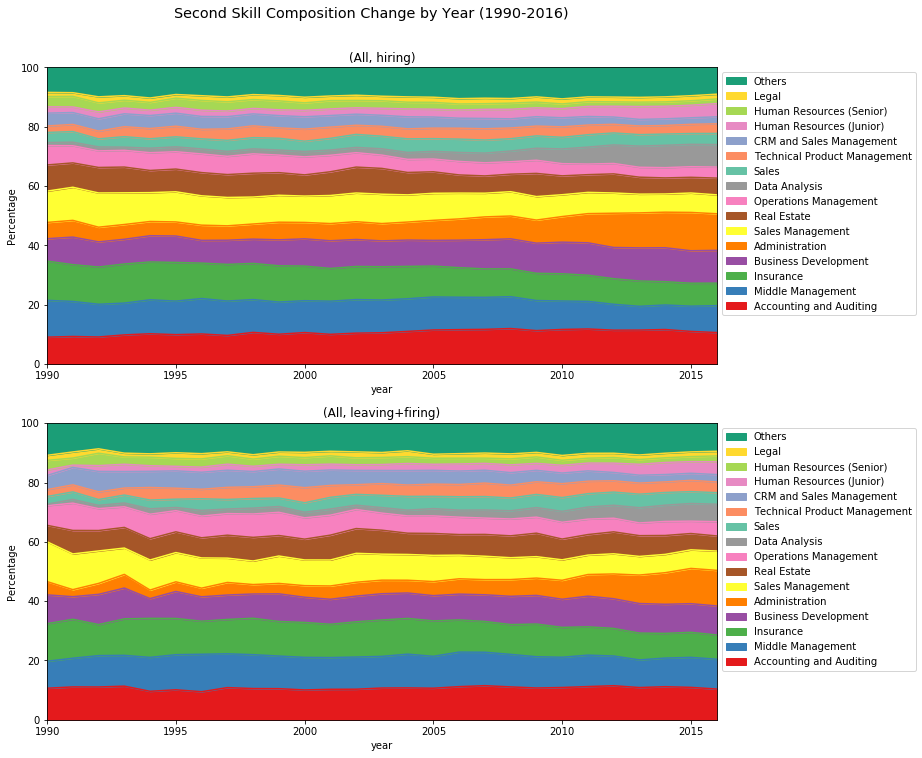

In [29]:
skill2_to_plot = empl_changes_df.loc[lambda df:(df.skill2!='')&(df.skill1=="Banking and Finance")]

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill2_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [30]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Financial Analyst,1701,1.50,Accounting,52.78,Bachelors,43.50
1,Vice President,1679,1.48,Oversight,17.56,None/Unknown,19.15
2,Analyst,1650,1.46,Business,8.02,Masters excl. MBA,17.20
3,Associate,1287,1.14,Operations,7.54,MBA,15.26
4,Fund Accountant,919,0.81,Marketing,6.98,Doctorate (PhD/JD/MD),1.81
5,Manager,915,0.81,Technology,2.78,High school,1.61
6,Credit Analyst,828,0.73,Hr,2.65,Associates,0.76
7,Assistant Manager,694,0.61,Legal,0.72,Vocational degree,0.71
8,Director,677,0.60,Production,0.50,NaN,NaN
9,Assistant Vice President,621,0.55,Management,0.48,NaN,NaN


,job_role,depmt,edu,f_elite
7724848,Internal Audit & Controls Head Global Consumer Group,ACCOUNTING,Masters excl. MBA,False
8009652,Banksjef,,None/Unknown,False
7251601,Equity Research - Consumer,TECHNOLOGY,Bachelors,False
7480052,Global Trade Finance Officer,ACCOUNTING,Masters excl. MBA,False
4428300,Home Service Specialist ll,MARKETING,Associates,False
2950472,Portfolio Performance and Middle Office Analyst,,MBA,False
6656640,Audit Manager,ACCOUNTING,Bachelors,True
5291336,Account Manager,,Bachelors,False
9102230,senior Accoutant/Business Analist,,Bachelors,False
8707578,Senior Business Associate,,MBA,False


,job_role,count,prop,depmt,prop,edu,prop
0,Vice President,1631,1.56,Accounting,31.44,Bachelors,38.77
1,Branch Manager,1434,1.37,Marketing,17.33,None/Unknown,25.75
2,Manager,1083,1.03,Oversight,16.65,MBA,16.34
3,Assistant Manager,875,0.84,Operations,13.70,Masters excl. MBA,11.77
4,Analyst,755,0.72,Business,9.44,High school,2.63
5,Business Analyst,674,0.64,Hr,4.95,Doctorate (PhD/JD/MD),2.21
6,Director,644,0.62,Technology,3.78,Associates,1.57
7,Associate,641,0.61,Production,1.19,Vocational degree,0.96
8,Relationship Manager,623,0.59,Legal,0.89,NaN,NaN
9,Customer Service Representative,610,0.58,Management,0.60,NaN,NaN


,job_role,depmt,edu,f_elite
7342774,Assistant Vice President,,None/Unknown,False
2782667,Cash Management Sales Head,MARKETING,None/Unknown,False
1773117,Supervisor II AVP,,None/Unknown,False
5421899,Customer Relationship Manager,,Associates,False
8792239,Director | Business Consulting Charles Schwab,OVERSIGHT,MBA,False
8673183,Regional Operations Manager,OPERATIONS,MBA,False
6771951,Product Marketing,MARKETING,None/Unknown,False
9673352,Vice President of Business Management and Strategy,BUSINESS,Masters excl. MBA,True
9377814,Director,OVERSIGHT,Doctorate (PhD/JD/MD),False
3127845,Manager,,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Financial Advisor,3728,3.66,Accounting,46.29,Bachelors,43.65
1,Vice President,2001,1.96,Oversight,17.77,None/Unknown,30.04
2,Branch Manager,1219,1.20,Marketing,16.75,MBA,10.88
3,Director,901,0.88,Business,7.65,Masters excl. MBA,8.45
4,Managing Director,839,0.82,Hr,4.26,High school,2.52
5,Relationship Manager,832,0.82,Operations,4.04,Doctorate (PhD/JD/MD),2.13
6,Personal Banker,820,0.80,Technology,1.78,Associates,1.25
7,Senior Vice President,730,0.72,Legal,0.60,Vocational degree,1.07
8,Financial Consultant,710,0.70,Management,0.45,NaN,NaN
9,Customer Service Representative,641,0.63,Production,0.40,NaN,NaN


,job_role,depmt,edu,f_elite
6841265,Finance Manager & Credit Controller,ACCOUNTING,High school,False
6627584,Senior Consultant,,None/Unknown,False
5098727,Financial Advisor,ACCOUNTING,None/Unknown,False
4377813,Banking,ACCOUNTING,MBA,False
2738849,Commercial Banking Officer,"ACCOUNTING,BUSINESS",MBA,False
981271,beleggingsspecialist,,None/Unknown,False
4061421,Vice President,,Bachelors,False
2698268,Research Analyst,TECHNOLOGY,Masters excl. MBA,True
364723,Citigold Relationship Manager,,Doctorate (PhD/JD/MD),False
493287,secretary,,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Analyst,1771,1.77,Accounting,37.41,Bachelors,33.63
1,Associate,1137,1.14,Marketing,18.01,Masters excl. MBA,21.83
2,Investment Banking Analyst,923,0.92,Oversight,15.03,None/Unknown,19.48
3,Relationship Manager,922,0.92,Business,14.89,MBA,19.29
4,Vice President,734,0.74,Operations,4.99,High school,2.18
5,Financial Analyst,646,0.65,Technology,4.87,Doctorate (PhD/JD/MD),1.97
6,Manager,569,0.57,Hr,2.97,Vocational degree,1.23
7,Director,543,0.54,Management,0.97,Associates,0.41
8,Assistant Manager,486,0.49,Legal,0.53,NaN,NaN
9,Credit Analyst,464,0.46,Production,0.33,NaN,NaN


,job_role,depmt,edu,f_elite
7191281,APS (BOBS) for Murex and Transcom,,Masters excl. MBA,False
2377759,Marketing Executive,MARKETING,Doctorate (PhD/JD/MD),False
765179,Financial Analyst,ACCOUNTING,Bachelors,False
8689599,UZMAN,,None/Unknown,False
7089610,Portfolio Manager,,Masters excl. MBA,False
337872,Contrôleur interne Junior,,Masters excl. MBA,False
9611987,Commercial Credit Specialist,"ACCOUNTING,BUSINESS",Bachelors,True
4536517,Investment Manager,ACCOUNTING,Bachelors,False
4924257,Spring Week,,Bachelors,False
1598223,Gestionnaire middle office taux,,Masters excl. MBA,False


,job_role,count,prop,depmt,prop,edu,prop
0,Teller,1896,2.12,Accounting,43.07,Bachelors,47.92
1,Customer Service Representative,1883,2.10,Marketing,25.91,None/Unknown,25.39
2,Personal Banker,1397,1.56,Operations,8.37,Masters excl. MBA,9.69
3,Bank Teller,1225,1.37,Oversight,7.19,MBA,5.93
4,Branch Manager,1185,1.32,Business,6.49,Associates,4.43
5,Analyst,1173,1.31,Hr,4.68,High school,4.31
6,Assistant Manager,735,0.82,Technology,2.43,Vocational degree,1.41
7,Associate,712,0.79,Production,0.76,Doctorate (PhD/JD/MD),0.93
8,Investment Banking Analyst,674,0.75,Legal,0.67,NaN,NaN
9,Financial Advisor,578,0.65,Management,0.41,NaN,NaN


,job_role,depmt,edu,f_elite
219350,Loan Processor,ACCOUNTING,High school,False
8272503,Investment Analyst,ACCOUNTING,None/Unknown,False
6859915,Financial Center Manager,ACCOUNTING,Bachelors,False
5529691,Associate Portfolio Manager,,Bachelors,False
9241173,Senior Broker,,Bachelors,False
339285,Senior Financial Sales Advisor,"ACCOUNTING,MARKETING",Bachelors,False
611439,Financial Service Representative,"ACCOUNTING,MARKETING",Doctorate (PhD/JD/MD),False
1246842,Foreign Exchange Services Consultant,HR,Masters excl. MBA,False
2913072,Personal Banker and Trainer,,None/Unknown,False
2603113,Collections Officer,ACCOUNTING,High school,False


## By Country.

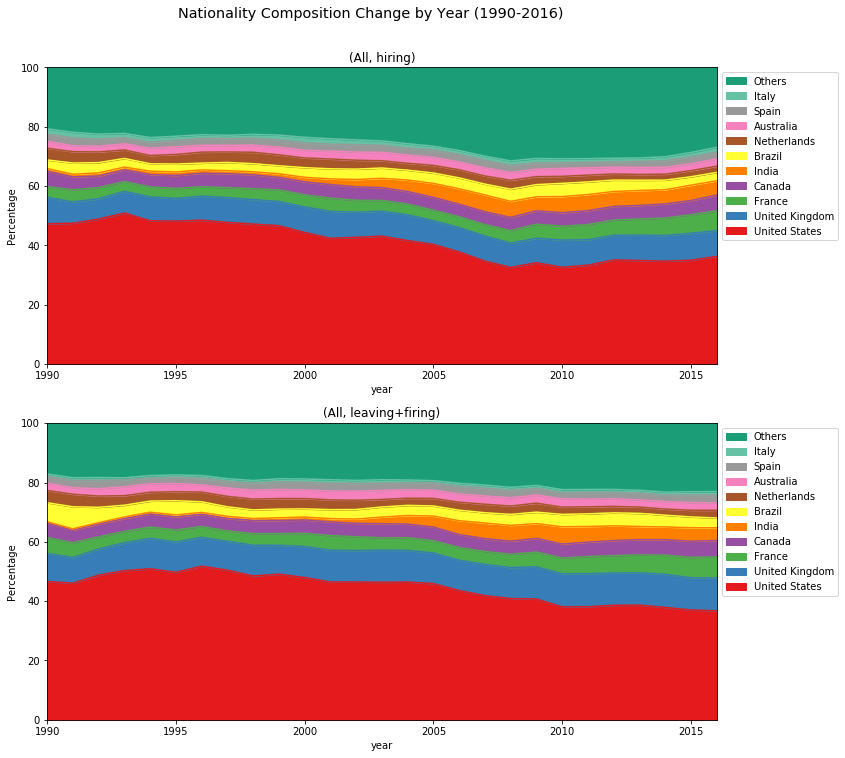

In [31]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 10 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [cntry_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016),xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

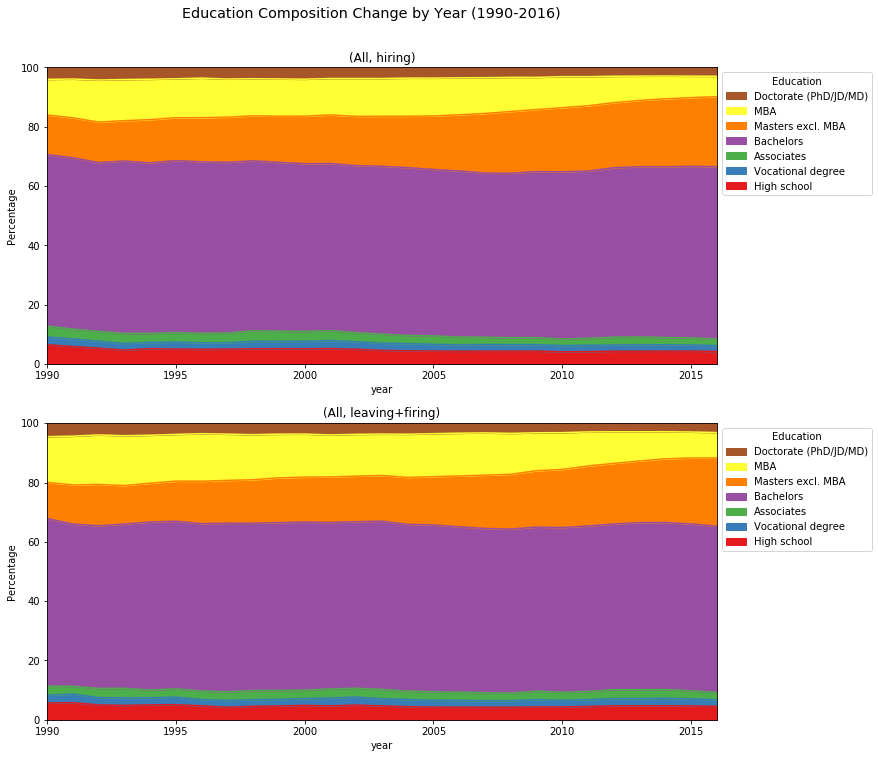

In [32]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2,fig_func=lambda x:x.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016), xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



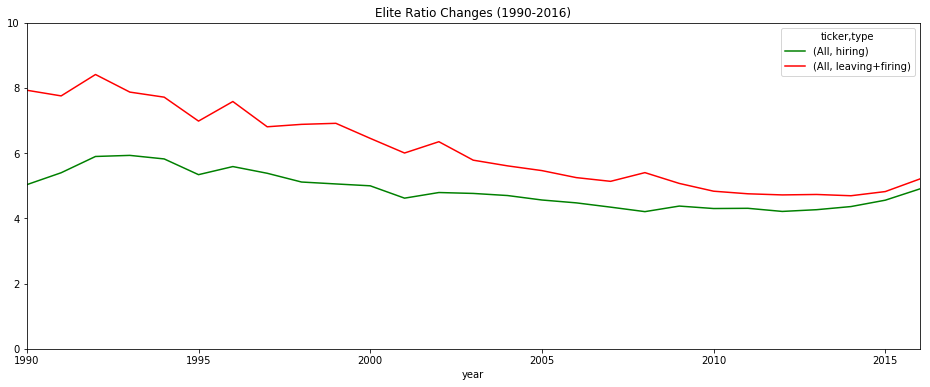

In [33]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'), xlefts
):
    grp.loc[lambda df:df.year>=xleft].pivot_table(
        index='year',columns=['ticker','type'],values='f_elite',
        aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
    ).plot(
        xlim=(1990,2016),color=color_styles,ylim=(0,10),
        title="Elite Ratio Changes (1990-2016)",figsize=(16,6)
    )
    ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [36]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified"),
    'GO': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

,Industry group,NAICS2
0,Natural Resources and Mining,"11, 21"
1,Construction,23
2,Manufacturing,"31, 32, 33"
3,"Trade, Transportation, and Utilities","42, 44, 45, 48, 49, 22"
4,Information,51
5,Financial Activities,"52, 53"
6,Professional and Business Services,"54, 55, 56"
7,Education and Health Services,"61, 62"
8,Leisure and Hospitality,"71, 72"
9,Other Services,81


Note: `46` seems to be a wrong NAICS2 code.

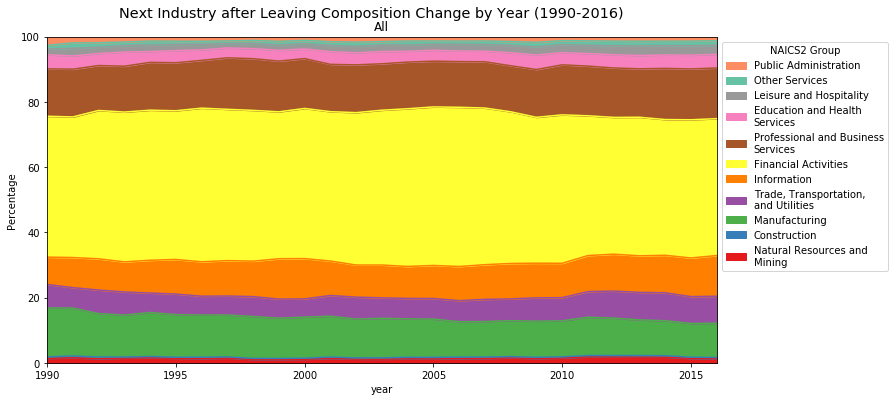

In [37]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), iterator_for_axis(
        fig_func=lambda x:x.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), xlefts
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx, xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

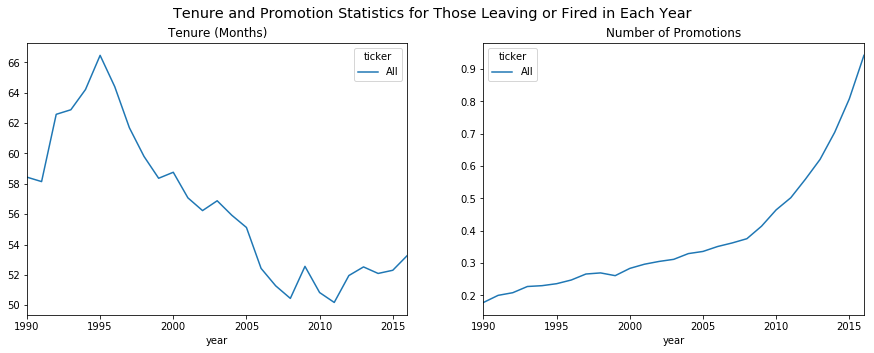

In [38]:
for (ticker, grp), xleft in zip(empl_changes_df.groupby('ticker'),xlefts):
    # Calculate.
    to_plot = grp.loc[lambda df:(df.type!='hiring')&(df.year>=xleft)&(df.year<=2016)].astype(
        {'tenure':'Int64','nprom':'Int64'}
    ).pivot_table(
        columns=['ticker'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
    )

    # Plot.
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
    to_plot['tenure'].plot(
        title="Tenure (Months)",ax=ax1,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
    to_plot['nprom'].plot(
        title="Number of Promotions",ax=ax2,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
plt.show()